### А/А-тест
Тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

Описание колонок        
experimentVariant – вариант эксперимента       
version – версия приложения       
purchase – факт покупки        

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [3]:
# Подгрузим данные и глянем на них
df = pd.read_csv('hw_aa.csv', sep=';', index_col='Unnamed: 0')

In [4]:
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127018 entries, 1 to 127018
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uid                127018 non-null  object
 1   experimentVariant  127018 non-null  int64 
 2   version            127018 non-null  object
 3   purchase           127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.8+ MB


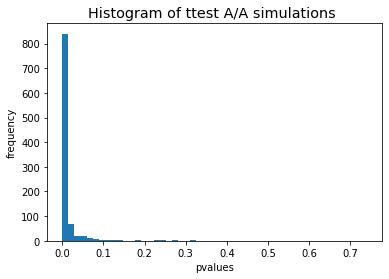

0.939

In [6]:
# Запустим первый A/A тест и посмотрим что будет

simulations = 1000
n_s = 1000
res = []

df_0 = df.query("experimentVariant == 0")
df_1 = df.query("experimentVariant == 1")

for i in tqdm(range(simulations)):
    s0 = df_0.purchase.sample(n_s, replace = False).values
    s1 = df_1.purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s0, s1, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем и надеемся что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

In [8]:
# Альфа сильно превышен - где-то есть ошибка

In [9]:
# Из доступных данный проблемы могут быть только в версии приложения
# (по всем другим данным и считается конверсия)
df_1 = df.groupby(['version', 'experimentVariant'], as_index=False).agg({'uid': 'count', 'purchase': 'sum'})
df_1['c'] = df_1.purchase / df_1.uid
df_1

,version,experimentVariant,uid,purchase,c
0,v2.8.0,0,41283,41,0.000993
1,v2.8.0,1,41552,1895,0.045606
2,v2.9.0,0,11921,890,0.074658
3,v2.9.0,1,12033,858,0.071304
4,v3.7.4.0,0,4204,252,0.059943
5,v3.7.4.0,1,4221,266,0.063018
6,v3.8.0.0,0,5694,328,0.057604
7,v3.8.0.0,1,6110,384,0.062848


In [10]:
# Видим аномально маленькое занчение конверсии для v2.8.0 версии приложения, попробуем исключить ее

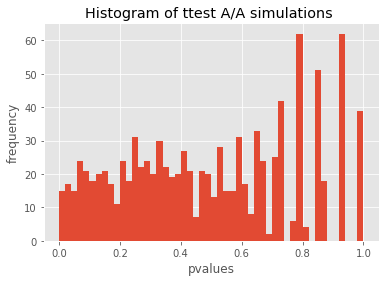

0.04

In [11]:
simulations = 1000
n_s = 1000
res = []

df_0 = df.query("experimentVariant == 0 and version != 'v2.8.0'")
df_1 = df.query("experimentVariant == 1 and version != 'v2.8.0'")

for i in tqdm(range(simulations)):
    s0 = df_0.purchase.sample(n_s, replace = False).values
    s1 = df_1.purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s0, s1, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем и надеемся что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

In [ ]:
# Видим значение меньше альфа, значит в таком виде сплит-система работает корректно

### Вывод 
    Нужно починить сплит-систему на v2.8.0 версии приложения в 0 варианте эксперимента - оттуда почему-то приходит много меньшее количество фактов покупки(может быть они просто не считаются в системе А|A теста или еще хуже - пользователи из-за какого-то сбоя при настройке сплит-системы вообще не могут совершить покупку), а в остальном она работает корректно